## Load Data, Get Representation, Train Binary Classification RNN Model
(Binary classification on log fold change)

In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("src/")
import operator
from importlib import reload
import src.preprocessing.data_loading as data_loading
import models.experiment as experiment
import models.rnn as rnn
import analysis.umap_analysis as umap
import analysis.scatter_plots as scatter_plots
import analysis.evaluation as evaluation
from preprocessing.X_representation import RAA_to_seq
from preprocessing.X_representation_utils import initialize_Proc2Vec_embeddings
from utils.utils import find_3mer
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib import pyplot as plt
from tensorflow import keras

2023-01-27 15:56:04.430181: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-27 15:56:36.738363: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/anaconda3/envs/ml_phage/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load the pre-trained model

In [3]:
R3_lib = data_loading.read_data_and_preprocess(datafile="12ca5-MDM2-mCDH2-R3.csv")
protein_of_interest = "MDM2"
other_protein = "12ca5"
(
    X,
    mdm2_y,
    mdm2_y_raw,
    ca5_y,
    ca5_y_raw,
    peptides,
    FEATURE_LIST,
) = data_loading.build_dataset(
    R3_lib,
    protein_of_interest=protein_of_interest,
    other_protein=other_protein,
    aa_representations=[
        data_loading.AA_REPRESENTATION.PRO2VEC,
        data_loading.AA_REPRESENTATION.RAA,
        data_loading.AA_REPRESENTATION.PHYSIOCHEM_PROPERTIES,
        data_loading.AA_REPRESENTATION.ONE_HOT,
    ],
)

(
    X_train,
    X_test,
    mdm2_y_train,
    mdm2_y_test,
    mdm2_y_raw_train,
    mdm2_y_raw_test,
    ca5_y_train,
    ca5_y_test,
    ca5_y_raw_train,
    ca5_y_raw_test,
    peptides_train,
    peptides_test,
) = train_test_split(
    X,
    mdm2_y,
    mdm2_y_raw,
    ca5_y,
    ca5_y_raw,
    peptides,
    test_size=0.2,
    shuffle=True,
    random_state=5,
)
mdm2_model = experiment.BinaryClassificationExperiment().train(
    X_train,
    mdm2_y_train,
    rnn.Joint_BinaryClassificationRNN_gelu,
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    # After initial training we are loading a pretrained model from memory
    load_trained_model=True,
    model_save_name="mdm2_bilstm_best.h5",
)
mdm2_y_pred_raw = mdm2_model(X_test)
mdm2_y_pred = mdm2_y_pred_raw > 0.5

print("MDM2")
evaluation.classification_evaluation_joint(mdm2_y_test, mdm2_y_pred)


/Users/yitongtseo/Documents/GitHub/ml_phage_display/src/preprocessing/y_representation.py:66: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  lib["pvalues"] = sp.stats.ttest_ind(


 - log P value cutoff is -0.44638568713238386, and log FC value cutoff is -0.6565247891915524
MDM2
P-VAL
	 accuracy:  0.7200364575421541
	 precision:  0.688961038961039
	 recall:  0.8868765672889384
	 # neg predictions:  1963
	 # pos predictions:  4620
Log Fold
	 accuracy:  0.8798420173173325
	 precision:  0.8765533028122956
	 recall:  0.9933296275708727
	 # neg predictions:  467
	 # pos predictions:  6116


In [4]:
# compute 12ca5 preditions by reversing MDM2 FC preditions
ca5_y_pred_raw_derived_from_mdm2 = np.copy(mdm2_y_pred_raw)
ca5_y_pred_raw_derived_from_mdm2[:, 1] = 1-ca5_y_pred_raw_derived_from_mdm2[:,1]
ca5_y_pred_derived_from_mdm2 = ca5_y_pred_raw_derived_from_mdm2 > 0.5

print('\n12ca5 Derived from inverted MDM2 Model Output')
# evaluate accuracy, precision, recall of trianed model
evaluation.classification_evaluation_joint(ca5_y_test, ca5_y_pred_derived_from_mdm2)



12ca5 Derived from inverted MDM2 Model Output
P-VAL
	 accuracy:  0.7200364575421541
	 precision:  0.688961038961039
	 recall:  0.8868765672889384
	 # neg predictions:  1963
	 # pos predictions:  4620
Log Fold
	 accuracy:  0.8798420173173325
	 precision:  0.9229122055674518
	 recall:  0.3634064080944351
	 # neg predictions:  6116
	 # pos predictions:  467


## UMAPs!

In [5]:
embedding=umap.embedding_classification(mdm2_model,X)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


The size we are going with for MDM2 hotspot 2999
The size we are going with for 12ca5 hotspot 3166


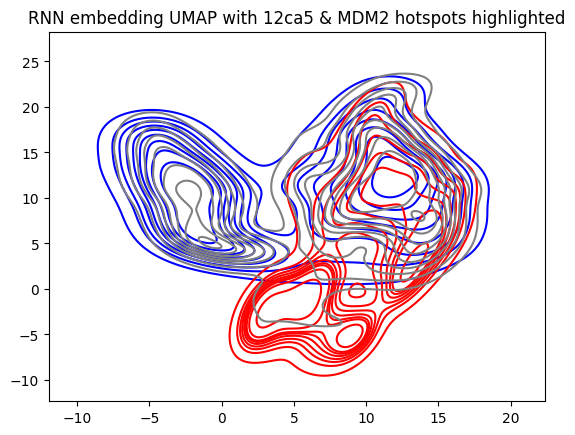

In [5]:
umap.UMAP_dual_vis(embedding, mdm2_y_raw,kde=True)

The size we are going with for MDM2 hotspot 2999
The size we are going with for 12ca5 hotspot 3166


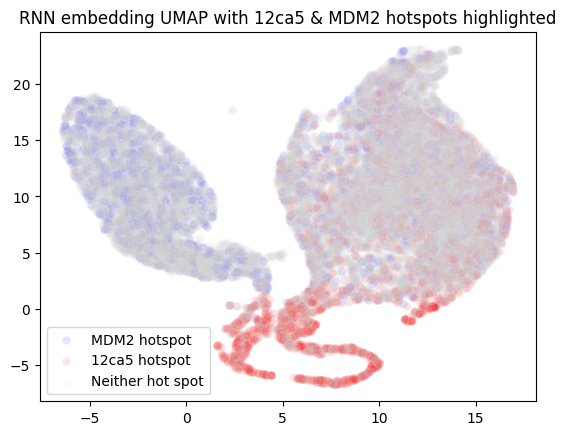

In [6]:
umap.UMAP_dual_vis(embedding, mdm2_y_raw)

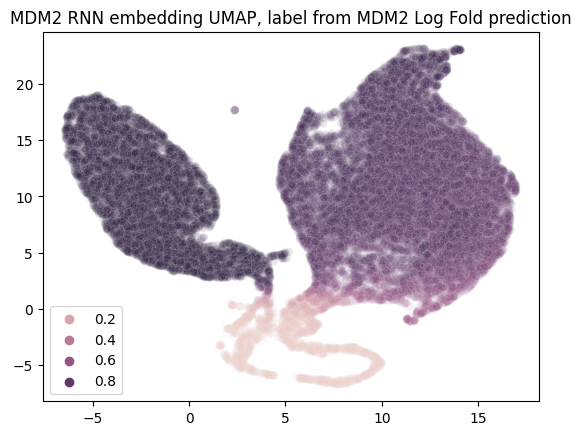

In [9]:
umap.UMAP_vis(
    embedding,
    mdm2_model(X)[:, 1],
    title="MDM2 RNN embedding UMAP, label from MDM2 Log Fold prediction",
)

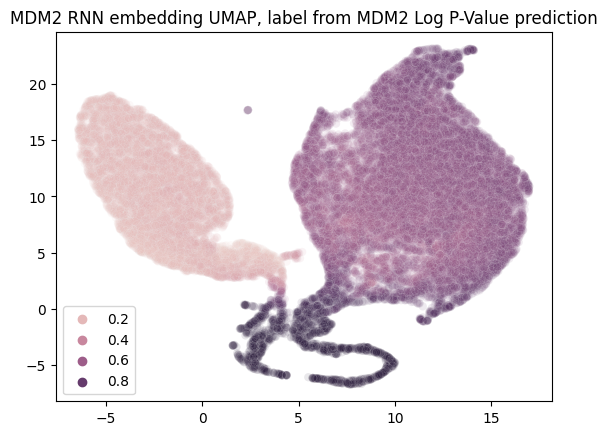

In [10]:
umap.UMAP_vis(
    embedding,
    mdm2_model(X)[:, 0],
    title="MDM2 RNN embedding UMAP, label from MDM2 Log P-Value prediction",
)

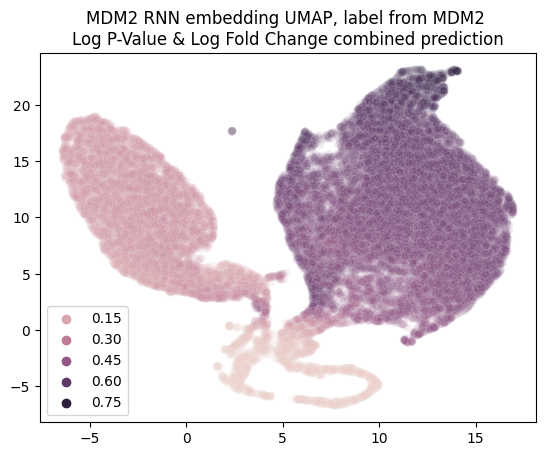

In [14]:
umap.UMAP_vis(
    embedding,
    mdm2_model(X)[:, 0] * mdm2_model(X)[:, 1],
    title="MDM2 RNN embedding UMAP, label from MDM2 \nLog P-Value & Log Fold Change combined prediction",
)

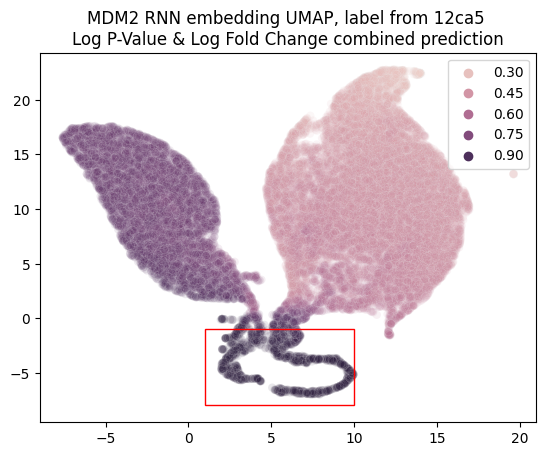

In [9]:
import matplotlib
rect = matplotlib.patches.Rectangle(
    (1, -8), 9, 7, linewidth=1, edgecolor="r", facecolor="none"
)
umap.UMAP_vis(
    embedding,
    1 - mdm2_model(X)[:, 0] * mdm2_model(X)[:, 1],
    title="MDM2 RNN embedding UMAP, label from 12ca5 \nLog P-Value & Log Fold Change combined prediction",
    rectangle=rect
)

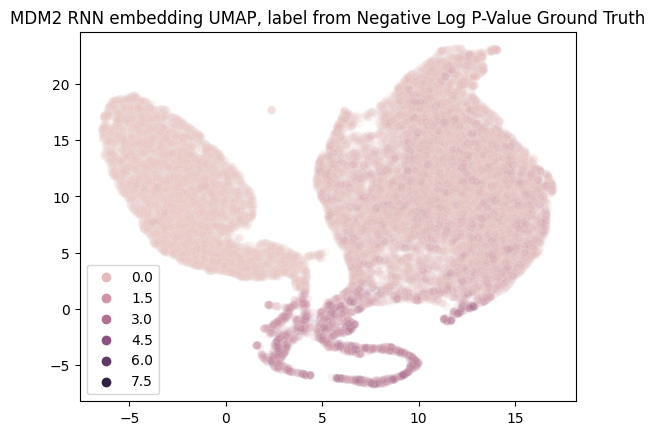

In [11]:
umap.UMAP_vis(
    embedding,
    mdm2_y_raw[:, 0],
    title="MDM2 RNN embedding UMAP, label from Negative Log P-Value Ground Truth",
)

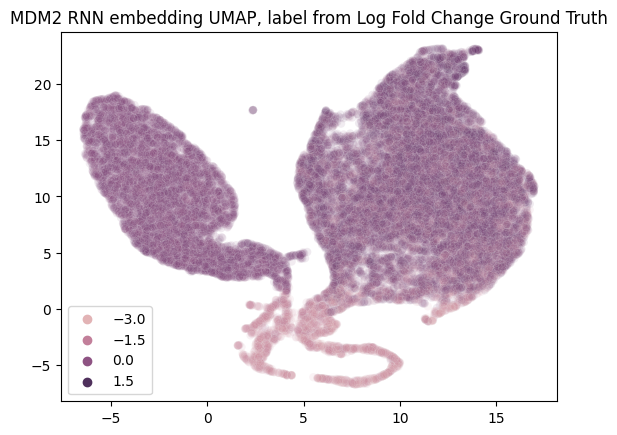

In [12]:
umap.UMAP_vis(
    embedding,
    mdm2_y_raw[:, 1],
    title="MDM2 RNN embedding UMAP, label from Log Fold Change Ground Truth",
)

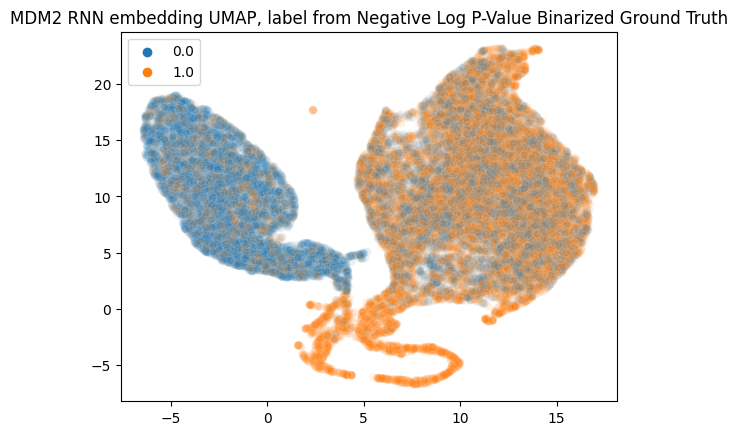

In [15]:
umap.UMAP_vis(
    embedding,
    mdm2_y[:, 0],
    title="MDM2 RNN embedding UMAP, label from Negative Log P-Value Binarized Ground Truth",
)

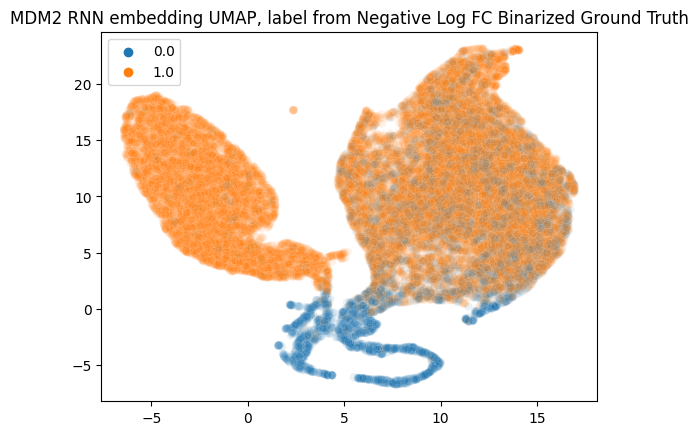

In [16]:
umap.UMAP_vis(
    embedding,
    mdm2_y[:, 1],
    title="MDM2 RNN embedding UMAP, label from Negative Log FC Binarized Ground Truth",
)